### Analysis and visualisation of Bartlett results

* Embed 'background data'
* Embed recalled stories for each model
* Project into 2D
* Do the recalled stories get closer to the background distribution?

In [20]:
!pip install sentence-transformers

  Obtaining dependency information for sentence-transformers from https://files.pythonhosted.org/packages/f8/c4/99a9386808025d5a546576243bfd3b1eb669f978b8a0e05a1253eaf89bf0/sentence_transformers-3.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 9.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import glob
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import numpy as np
import pandas as pd

bartlett = """One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man heard one of the warriors say, "Quick, let us go home: that man has been hit." Now he thought: "Oh, they are ghosts." He did not feel sick, but they said he had been shot.
So the canoes went back to Egulac and the young man went ashore to his house and made a fire. And he told everybody and said: "Behold I accompanied the ghosts, and we went to fight. Many of our fellows were killed, and many of those who attacked us were killed. They said I was hit, and I did not feel sick."
He told it all, and then he became quiet. When the sun rose he fell down. Something black came out of his mouth. His face became contorted. The people jumped up and cried.
He was dead."""

In [298]:
directory_path = 'bartlett_data_final'

# Initialize a dictionary to hold combined data
combined_data = {}
combined_data[1] = {}

# Function to load data from a pickle file
def load_pickle_data(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
    return data

# Read and combine data from all pickle files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.pkl'):  # Ensures that we are reading only pickle files
        file_path = os.path.join(directory_path, filename)
        data = load_pickle_data(file_path)

        for category in ['Universe', 'Politics', 'Health', 'Sport', 'Technology', 'Nature']:
            if category not in combined_data[1]:
                combined_data[1][category] = {}
            for temp in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5]:
                if temp not in combined_data[1][category]:
                    combined_data[1][category][temp] = []
                # Extend the list of strings for this category and temperature
                if temp == 0:
                    combined_data[1][category][temp].append(data[1][category][temp])
                else:
                    combined_data[1][category][temp].extend(data[1][category][temp])

d = combined_data

In [277]:
dataset = load_dataset('tarekziade/wikipedia-topics')
df = dataset['train'].to_pandas()

def get_texts_by_category(category, dataframe):
    # Filter the DataFrame for rows where the category list contains the specified category
    filtered_df = dataframe[~dataframe['categories'].apply(lambda x: 'People' in x)]
    filtered_df = dataframe[dataframe['categories'].apply(lambda x: category in x)]
    return filtered_df['text'].sample(frac=1).tolist()

universe_txts = [i[:len(bartlett)] for i in get_texts_by_category('Universe', df)][0:1000]
politics_txts = [i[:len(bartlett)] for i in get_texts_by_category('Politics', df)][0:1000]
health_txts = [i[:len(bartlett)] for i in get_texts_by_category('Health', df)][0:1000]
sport_txts = [i[:len(bartlett)] for i in get_texts_by_category('Sports', df)][0:1000]
tech_txts = [i[:len(bartlett)] for i in get_texts_by_category('Technology', df)][0:1000]
nature_txts = [i[:len(bartlett)] for i in get_texts_by_category('Nature', df)][0:1000]
    
temp = 0.1
universe_stories = d[1]['Universe'][temp] 
politics_stories = d[1]['Politics'][temp] 
health_stories = d[1]['Health'][temp] 
sport_stories =  d[1]['Sport'][temp]
tech_stories = d[1]['Technology'][temp]
nature_stories = d[1]['Nature'][temp]

Found cached dataset parquet (/Users/eleanorspens/.cache/huggingface/datasets/tarekziade___parquet/tarekziade--wikipedia-topics-6c8d174fbc49a7ad/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [278]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def embed_texts(texts):
    return model.encode(texts)
   
universe_embeddings = np.array([embed_texts([txt]) for txt in universe_txts])
politics_embeddings = np.array([embed_texts([txt]) for txt in politics_txts])
health_embeddings = np.array([embed_texts([txt]) for txt in health_txts])
sport_embeddings = np.array([embed_texts([txt]) for txt in sport_txts])
tech_embeddings = np.array([embed_texts([txt]) for txt in tech_txts])
nature_embeddings = np.array([embed_texts([txt]) for txt in nature_txts])

universe_story_embeddings = np.array([embed_texts([txt[:len(bartlett)]]) for txt in universe_stories])
politics_story_embeddings = np.array([embed_texts([txt[:len(bartlett)]]) for txt in politics_stories])
health_story_embeddings = np.array([embed_texts([txt[:len(bartlett)]]) for txt in health_stories])
sport_story_embeddings = np.array([embed_texts([txt[:len(bartlett)]]) for txt in sport_stories])
tech_story_embeddings = np.array([embed_texts([txt[:len(bartlett)]]) for txt in tech_stories])
nature_story_embeddings = np.array([embed_texts([txt[:len(bartlett)]]) for txt in nature_stories])

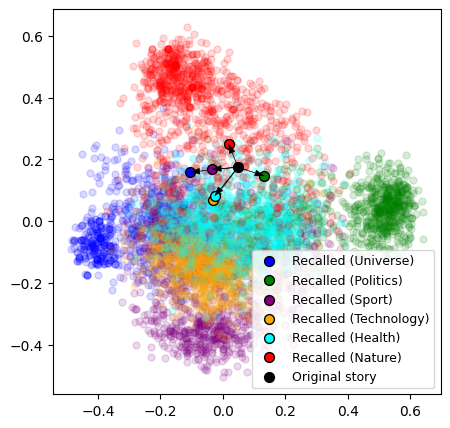

In [296]:
# Function to embed a list of texts and immediately remove the batch dimension
def embed_texts(model, texts):
    return model.encode(texts, convert_to_numpy=True)

bartlett_text = bartlett
bartlett_embedding = embed_texts(model, [bartlett])
bartlett_embedding = bartlett_embedding.reshape(1, -1)  # Ensure it has the right shape

def calculate_mean_embeddings(*embedding_lists):
    means = [np.mean(embeddings, axis=0) for embeddings in embedding_lists]
    return np.array(means)

# Apply PCA to all embeddings
all_embeddings = np.concatenate([universe_embeddings, politics_embeddings, sport_embeddings, tech_embeddings,  health_embeddings, nature_embeddings, 
                                 universe_story_embeddings, politics_story_embeddings, sport_story_embeddings, tech_story_embeddings, health_story_embeddings,  nature_story_embeddings,
                                ])
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings.reshape(all_embeddings.shape[0], all_embeddings.shape[-1]))

# Apply PCA to the Bartlett embedding using the already fitted PCA model
reduced_bartlett_embedding = pca.transform(bartlett_embedding)

# Calculate the reduced means after PCA for consistency in transformation
mean_embeddings = calculate_mean_embeddings(universe_embeddings, politics_embeddings, sport_embeddings, tech_embeddings , health_embeddings, nature_embeddings,
                                            universe_story_embeddings, politics_story_embeddings, sport_story_embeddings, tech_story_embeddings, health_story_embeddings, nature_story_embeddings
                                           )
reduced_means = pca.transform(mean_embeddings.reshape(mean_embeddings.shape[0], mean_embeddings.shape[-1]))

# Function to plot the embeddings, their means, and the Bartlett story embedding
def plot_embeddings_with_means_and_bartlett(embeddings, reduced_means, bartlett_embedding, labels, colors):
    plt.figure(figsize=(5, 5))
    # Plot all embeddings
    group_sizes = [len(embed) for embed in [universe_embeddings, politics_embeddings, sport_embeddings, tech_embeddings , health_embeddings, nature_embeddings,
                                            universe_story_embeddings, politics_story_embeddings, sport_story_embeddings, tech_story_embeddings , health_story_embeddings,  nature_story_embeddings
                                           ]]
    start_idx = 0
    for i, size in enumerate(group_sizes):
        if i < 6:
            end_idx = start_idx + size
            plt.scatter(embeddings[start_idx:end_idx, 0], embeddings[start_idx:end_idx, 1],
                        color=colors[i], alpha=0.15, s=25) #label=f'{labels[i]} data')  # Datasets with lower opacity
            start_idx = end_idx

    # Plot means
    for i, mean in enumerate(reduced_means):
        if i > 5:
            plt.scatter(mean[0], mean[1], color=colors[i], marker='o', s=50, edgecolors='black', label=f'{labels[i]}')  # Mean as 'x'
            plt.arrow(bartlett_embedding[0, 0], bartlett_embedding[0, 1], mean[0] - bartlett_embedding[0, 0], mean[1] - bartlett_embedding[0, 1],
                  color='black', shape='full', lw=0.2, length_includes_head=True, head_width=0.02)

    
    # Plot Bartlett story embedding
    plt.scatter(bartlett_embedding[0, 0], bartlett_embedding[0, 1], color='black', marker='o', edgecolors='black', s=50, label='Original story')
    
    
    #plt.xlabel('Component 1')
    #plt.ylabel('Component 2')
    plt.legend(fontsize=9, ncol=1, loc='lower right') #bbox_to_anchor=(1, 0.5))
    plt.savefig('Recalled 2D.png', bbox_inches='tight', dpi=300)
    plt.show()

# Labels and colors for each group
labels = ['Universe data', 'Politics data', 'Sport data', 'Technology data', 'Health data', 'Nature data',
          'Recalled (Universe)', 'Recalled (Politics)', 'Recalled (Sport)', 'Recalled (Technology)', 'Recalled (Health)', 'Recalled (Nature)'
         ]

colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'red',
          'blue', 'green', 'purple', 'orange', 'cyan', 'red'
         ]

plot_embeddings_with_means_and_bartlett(reduced_embeddings, reduced_means, reduced_bartlett_embedding, labels, colors)


In [299]:
# Function to calculate mean embedding of a list of embeddings
def mean_embedding(embeddings):
    return np.mean(embeddings, axis=0)

# Function to calculate cosine distance between two vectors
def cosine_distance(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Load the model
model = SentenceTransformer('all-MiniLM-L12-v2')

# Embedding the bartlett story
bartlett_embedding = embed_texts(model, [bartlett])[0]  # Remove batch dimension here

# Dictionary to store results
category_results = {}

# Categories and their respective texts and stories
categories = {
    'Universe': (universe_txts, universe_stories),
    'Politics': (politics_txts, politics_stories),
    'Health': (health_txts, health_stories),
    'Sport': (sport_txts, sport_stories),
    'Nature': (nature_txts, nature_stories),
    'Technology': (tech_txts, tech_stories)
}

# Compute mean embeddings and distances for each category
for category, (texts, stories) in categories.items():
    # Embed category texts and stories
    category_embeddings = np.array([embed_texts(model, [txt])[0] for txt in texts])  # Remove batch dimension
    story_embeddings = np.array([embed_texts(model, [txt[:len(bartlett)]])[0] for txt in stories])  # Remove batch dimension
    
    # Compute mean embeddings
    category_mean = mean_embedding(category_embeddings)
    story_mean = mean_embedding(story_embeddings)
    
    # Calculate distances
    distance_bartlett_category = cosine_distance(bartlett_embedding, category_mean)
    distance_story_category = cosine_distance(story_mean, category_mean)
    
    # Store results in dictionary
    category_results[category] = {
        'distance_bartlett_category': distance_bartlett_category,
        'distance_story_category': distance_story_category
    }

# Output the results dictionary
print(category_results)


{'Universe': {'distance_bartlett_category': 0.9860070049762726, 'distance_story_category': 0.9435305818915367}, 'Politics': {'distance_bartlett_category': 0.8174905478954315, 'distance_story_category': 0.7718380242586136}, 'Health': {'distance_bartlett_category': 0.8521137237548828, 'distance_story_category': 0.6716425716876984}, 'Sport': {'distance_bartlett_category': 0.9789750445634127, 'distance_story_category': 0.9738560616970062}, 'Nature': {'distance_bartlett_category': 0.8031518012285233, 'distance_story_category': 0.7248211205005646}, 'Technology': {'distance_bartlett_category': 0.9429393969476223, 'distance_story_category': 0.9232917055487633}}


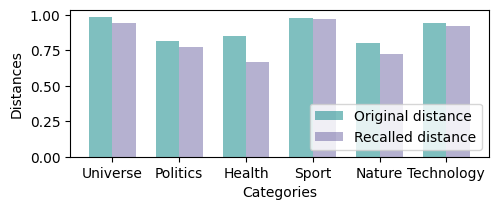

In [300]:
# Extract category names and corresponding distances
categories = list(category_results.keys())
distances_bartlett = [category_results[cat]['distance_bartlett_category'] for cat in categories]
distances_recalled = [category_results[cat]['distance_story_category'] for cat in categories]

x = range(len(categories))  # the label locations

fig, ax = plt.subplots(figsize=(5,2.2))
width = 0.35  # the width of the bars

# Create bars
rects1 = ax.bar(x, distances_bartlett, width, color='teal', label='Original distance', alpha=0.5)
rects2 = ax.bar([p + width for p in x], distances_recalled, width, color='darkslateblue', label='Recalled distance', alpha=0.4)

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Categories')
ax.set_ylabel('Distances')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(categories)
ax.legend(loc='lower right')

# Adding labels on top of the bars
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig('Recalled stories.png')
plt.show()
